In [25]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything

In [16]:
df_train = pd.read_csv("../data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("../data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [37]:
df_train.shape[0]

87554

<AxesSubplot:>

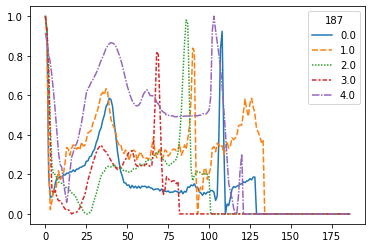

In [20]:
example = df_train.groupby(187).first()
sns.lineplot(data=example.T)

<AxesSubplot:xlabel='187', ylabel='Count'>

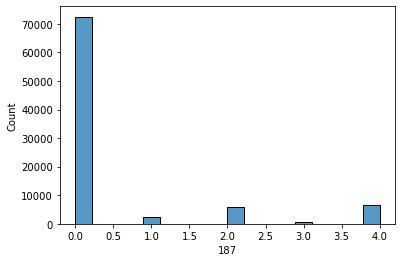

In [4]:
sns.histplot(df_train[187])

In [60]:
class TimeSeriesDataset(Dataset):
    def __init__(self, test=False):
        train_file = "../data/mitbih_train.csv"
        test_file = "../data/mitbih_test.csv"

        if test:
            self.df = pd.read_csv(test_file, header=None)
        else:
            self.df = pd.read_csv(train_file, header=None)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        X = self.df.loc[idx, list(range(187))].astype(np.float32)
        y = self.df.loc[idx, 187].astype(np.int8)
        return torch.tensor(X), torch.tensor(y, dtype=torch.long)
        

class MITDataModule(pl.LightningDataModule):
    def __init__(self, batch_size = 32, train_split=0.8, num_workers=4):
        super().__init__()
        self.batch_size = batch_size
        self.train_split = train_split
        self.num_workers = num_workers
        
    
    def setup(self, stage=None):
        timeseries_full = TimeSeriesDataset()
        train_length = int(self.train_split*len(timeseries_full))
        val_length = len(timeseries_full) - train_length
        self.train_set, self.val_set = random_split(timeseries_full, [train_length, val_length])
        self.test_set = TimeSeriesDataset(test=True)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, num_workers=self.num_workers)  

In [61]:
class RNNModel(pl.LightningModule):
    def __init__(self, 
                 input_size,
                 hidden_size,
                 num_layers,
                 dropout = 0,
                 num_classes = 5,
                 
    ):
        super(RNNModel, self).__init__()
        
        self.save_hyperparameters()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state

        x = x.unsqueeze(2)
        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        x = self.linear(out[:, -1, :])
        x = F.softmax(x, dim=1)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", val_loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = F.cross_entropy(y_hat, y)
        self.log("test_loss", test_loss)     

In [56]:
ds = TimeSeriesDataset()
x, y = next(iter(ds))

In [58]:
X

tensor([0.9779, 0.9265, 0.6814, 0.2451, 0.1544, 0.1912, 0.1520, 0.0858, 0.0588,
        0.0490, 0.0441, 0.0613, 0.0662, 0.0613, 0.0490, 0.0735, 0.0613, 0.0613,
        0.0662, 0.0686, 0.0956, 0.0760, 0.0931, 0.1054, 0.1152, 0.1029, 0.1176,
        0.1250, 0.1422, 0.1275, 0.1520, 0.1446, 0.1642, 0.1446, 0.1593, 0.1520,
        0.1544, 0.1422, 0.1520, 0.1520, 0.1471, 0.1324, 0.1275, 0.1348, 0.1373,
        0.1127, 0.1078, 0.1054, 0.1078, 0.0980, 0.0931, 0.1029, 0.1005, 0.1054,
        0.1029, 0.1176, 0.1054, 0.1225, 0.1275, 0.1422, 0.1471, 0.1446, 0.1740,
        0.2304, 0.2377, 0.2475, 0.2304, 0.2255, 0.1985, 0.1765, 0.1324, 0.1250,
        0.1176, 0.1225, 0.1127, 0.1299, 0.1152, 0.0833, 0.0000, 0.0662, 0.3064,
        0.6127, 0.8603, 1.0000, 0.9583, 0.7451, 0.3039, 0.1642, 0.2059, 0.1642,
        0.1029, 0.0956, 0.0907, 0.1005, 0.0956, 0.0980, 0.0931, 0.0980, 0.0956,
        0.1127, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [62]:
pl.seed_everything(1234)

model = RNNModel(1, 64, 1)
trainer = Trainer()

mit = MITDataModule()
trainer.fit(model, datamodule=mit)

Global seed set to 1234


TypeError: float() argument must be a string or a number, not 'NoneType'